In [1]:
from anndata import AnnData
import scanpy as sc
import squidpy as sq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
import umap

import scvi
from scvi.model import CondSCVI, DestVI

import torch

%matplotlib inline

Global seed set to 0


In [2]:
st_adata = sq.datasets.visium_fluo_adata()
st_adata.layers["counts"] = st_adata.X.copy()

sc.pp.normalize_total(st_adata, target_sum=10e4)
sc.pp.log1p(st_adata)

In [3]:
sc_adata = sq.datasets.sc_mouse_cortex()
sc.pp.filter_genes(sc_adata, min_counts=10)
sc_adata.layers["counts"] = sc_adata.X.copy()

sc.pp.highly_variable_genes(
    sc_adata,
    n_top_genes=2000,
    subset=True,
    layer="counts",
)

sc.pp.normalize_total(sc_adata, target_sum=10e4)
sc.pp.log1p(sc_adata)

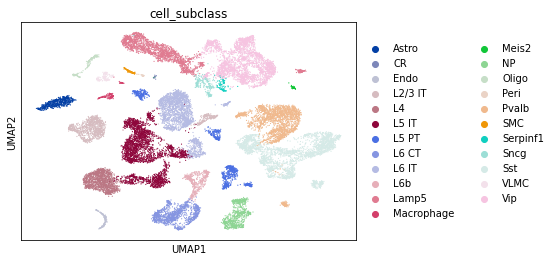

In [4]:
sc.pl.umap(sc_adata, color="cell_subclass")

In [5]:
intersect = np.intersect1d(sc_adata.var_names, st_adata.var_names)
st_adata = st_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()
G = len(intersect)

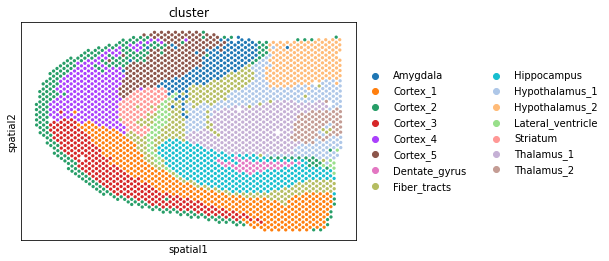

In [6]:
sc.pl.embedding(st_adata, basis="spatial", color="cluster")

In [7]:
CondSCVI.setup_anndata(sc_adata, layer="counts", labels_key="cell_subclass")
sc_model = CondSCVI(sc_adata, weight_obs=True)
sc_model.train(max_epochs=250)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     Using labels from adata.obs["cell_subclass"]                                        
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 21697 cells, 1232 vars, 1 batches,
         23 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        
INFO     Please do not further modify adata until model is trained.                          


/home/icb/anna.schaar/miniconda3/envs/ncem/lib/python3.8/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 250/250: 100%|████████████████████████████████████████████████████████████████████| 250/250 [07:53<00:00,  1.89s/it, loss=1.25e+04, v_num=1]


In [8]:
DestVI.setup_anndata(st_adata, layer="counts")
st_model = DestVI.from_rna_model(st_adata, sc_model)
st_model.train(max_epochs=2500)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 2800 cells, 1232 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/home/icb/anna.schaar/miniconda3/envs/ncem/lib/python3.8/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
/home/icb/anna.schaar/miniconda3/envs/ncem/lib/python3.8/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 2500/2500: 100%|████████████████████████████████████████████████████████████████| 2500/2500 [18:45<00:00,  2.22it/s, loss=1.48e+06, v_num=1]


In [9]:
cell_expression = []
node_types = []
gammas = []
proportions = []
spatial = []
for i, ct in enumerate(st_model.cell_type_mapping):
    prop = st_model.get_proportions()
    indices = np.where(prop[ct] > 0.03)[0]
    proportions.append(prop.iloc[indices,:])
    scale = np.array(st_model.get_scale_for_ct(ct, indices=indices))
    cell_expression.append(scale)
    nt = np.zeros((scale.shape[0], len(st_model.cell_type_mapping)))
    nt[:, i] = 1
    node_types.append(nt)
    g = np.array(st_model.get_gamma(indices=indices)[ct])
    gammas.append(g)
    spatial.append(st_adata.obsm['spatial'][indices,:])

proportions = pd.DataFrame(np.concatenate(proportions), columns=st_model.cell_type_mapping)
cell_expression = pd.DataFrame(np.concatenate(cell_expression), columns=st_adata.var_names)
cell_expression = np.log(1+ 1e4 * cell_expression)
node_types = pd.DataFrame(np.concatenate(node_types), columns=st_model.cell_type_mapping)
gammas = pd.DataFrame(np.concatenate(gammas))
spatial = pd.DataFrame(np.concatenate(spatial))

In [10]:
ad = AnnData(gammas)
ad.obsm['proportions'] = np.array(proportions)
ad.obsm['node_types'] = np.array(node_types)
ad.obsm['cell_expression'] = np.array(cell_expression)
ad.obsm['spatial'] = np.array(spatial)

ad.uns["node_type_names"] = {x: x for x in st_model.cell_type_mapping}

path = ''
fn = '/destvi_gamma/destVI_mousebrain.h5ad'
#ad.write(path + fn)

/home/icb/anna.schaar/miniconda3/envs/ncem/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [11]:
ad = AnnData(cell_expression)
ad.obsm['proportions'] = np.array(proportions)
ad.obsm['node_types'] = np.array(node_types)
ad.obsm['gamma'] = np.array(gammas)
ad.obsm['spatial'] = np.array(spatial)

ad.uns["node_type_names"] = {x: x for x in st_model.cell_type_mapping}
path = ''
fn = '/destvi/destVI_mousebrain.h5ad'
#ad.write(path + fn)